# Entrenamiento y Optimización de Modelos - Clasificador de Movimientos Corporales

Este notebook implementa la fase completa de modelado para el clasificador de movimientos corporales, incluyendo feature engineering, selección de características, entrenamiento de múltiples algoritmos, optimización de hiperparámetros y exportación del modelo final.

## Objetivo

Desarrollar un modelo robusto capaz de clasificar 5 tipos de movimientos corporales:
- *Caminar hacia la cámara*
- *Caminar de regreso*
- *Girar*
- *Sentarse*
- *Ponerse de pie*

## Pipeline de Modelado

1. **Carga del Dataset Procesado**
2. **Feature Engineering**
3. **Preparación de Datos**
4. **División de Datos**
5. **Entrenamiento de Modelos Base**
6. **Optimización de Hiperparámetros**
7. **Evaluación y Comparación**
8.  **Exportación del Modelo Final**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

# Para exportación de modelos
import joblib
import json
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("🔧 Librerías importadas exitosamente")

🔧 Librerías importadas exitosamente


## 1. Carga del Dataset Procesado

In [6]:
# Cargar dataset procesado del EDA
dataset_path = Path('data/motion_dataset_processed.csv')

if dataset_path.exists():
    df = pd.read_csv(dataset_path)
    print(f"✅ Dataset procesado cargado: {dataset_path}")
    print(f"📊 Dimensiones: {df.shape}")

if len(df) == 0:
    print("❌ No se pudo cargar el dataset. Verifica la ruta del archivo.")
    exit()

print(f"\n📋 Información del dataset:")
print(f"   • Registros totales: {len(df):,}")
print(f"   • Columnas: {len(df.columns)}")
print(f"   • Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Identificar estructura del dataset
coordinate_columns = [col for col in df.columns if col.endswith(('_x', '_y', '_z'))]
visibility_columns = [col for col in df.columns if col.endswith('_v')]

print(f"   • Coordenadas: {len(coordinate_columns)} columnas")
print(f"   • Visibilidad: {len(visibility_columns)} columnas")

✅ Dataset procesado cargado: data\motion_dataset_processed.csv
📊 Dimensiones: (15995, 54)

📋 Información del dataset:
   • Registros totales: 15,995
   • Columnas: 54
   • Memoria: 7.36 MB
   • Coordenadas: 39 columnas
   • Visibilidad: 13 columnas


## 2. Feature Engineering

In [7]:
# Crear una copia del dataset para trabajar
df_enhanced = df.copy()

def calculate_angle_3_points(p1, p2, p3):
    """
    Calcula el ángulo formado por tres puntos (p1-p2-p3)
    p2 es el vértice del ángulo
    """
    # Vectores desde p2
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    
    # Calcular ángulo
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
    cos_angle = np.clip(cos_angle, -1, 1)
    angle = np.arccos(cos_angle)
    
    return np.degrees(angle)

def calculate_distance(p1, p2):
    """Calcula distancia euclidiana entre dos puntos"""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def safe_get_coords(row, landmark_name, coord):
    """Obtiene coordenadas de forma segura"""
    col_name = f"{landmark_name}_{coord}"
    if col_name in row.index:
        return row[col_name]
    return np.nan

print("\n📐 CALCULANDO ÁNGULOS BIOMECÁNICOS...")

# 1. ÁNGULOS DE LAS PIERNAS (fundamentales para sit/stand/walk)
# Ángulo de la rodilla izquierda (cadera-rodilla-tobillo)
angles_left_knee = []
for idx, row in df_enhanced.iterrows():
    try:
        hip_left = (safe_get_coords(row, 'left_hip', 'x'), safe_get_coords(row, 'left_hip', 'y'))
        knee_left = (safe_get_coords(row, 'left_knee', 'x'), safe_get_coords(row, 'left_knee', 'y'))
        ankle_left = (safe_get_coords(row, 'left_ankle', 'x'), safe_get_coords(row, 'left_ankle', 'y'))
        
        if not any(pd.isna([hip_left[0], hip_left[1], knee_left[0], knee_left[1], ankle_left[0], ankle_left[1]])):
            angle = calculate_angle_3_points(hip_left, knee_left, ankle_left)
            angles_left_knee.append(angle)
        else:
            angles_left_knee.append(90)
    except:
        angles_left_knee.append(90)

df_enhanced['angle_left_knee'] = angles_left_knee

# Ángulo de la rodilla derecha
angles_right_knee = []
for idx, row in df_enhanced.iterrows():
    try:
        hip_right = (safe_get_coords(row, 'right_hip', 'x'), safe_get_coords(row, 'right_hip', 'y'))
        knee_right = (safe_get_coords(row, 'right_knee', 'x'), safe_get_coords(row, 'right_knee', 'y'))
        ankle_right = (safe_get_coords(row, 'right_ankle', 'x'), safe_get_coords(row, 'right_ankle', 'y'))
        
        if not any(pd.isna([hip_right[0], hip_right[1], knee_right[0], knee_right[1], ankle_right[0], ankle_right[1]])):
            angle = calculate_angle_3_points(hip_right, knee_right, ankle_right)
            angles_right_knee.append(angle)
        else:
            angles_right_knee.append(90)
    except:
        angles_right_knee.append(90)

df_enhanced['angle_right_knee'] = angles_right_knee

# 2. ÁNGULOS DEL TRONCO (fundamentales para inclinación y turning)
trunk_angles = []
for idx, row in df_enhanced.iterrows():
    try:
        # Punto medio de hombros
        shoulder_left = (safe_get_coords(row, 'left_shoulder', 'x'), safe_get_coords(row, 'left_shoulder', 'y'))
        shoulder_right = (safe_get_coords(row, 'right_shoulder', 'x'), safe_get_coords(row, 'right_shoulder', 'y'))
        
        # Punto medio de caderas
        hip_left = (safe_get_coords(row, 'left_hip', 'x'), safe_get_coords(row, 'left_hip', 'y'))
        hip_right = (safe_get_coords(row, 'right_hip', 'x'), safe_get_coords(row, 'right_hip', 'y'))
        
        if not any(pd.isna([shoulder_left[0], shoulder_right[0], hip_left[0], hip_right[0]])):
            shoulder_center = ((shoulder_left[0] + shoulder_right[0])/2, (shoulder_left[1] + shoulder_right[1])/2)
            hip_center = ((hip_left[0] + hip_right[0])/2, (hip_left[1] + hip_right[1])/2)
            
            # Calcular inclinación del tronco respecto a la vertical
            trunk_vector = [shoulder_center[0] - hip_center[0], shoulder_center[1] - hip_center[1]]
            vertical_vector = [0, 1]
            
            dot_product = trunk_vector[0] * vertical_vector[0] + trunk_vector[1] * vertical_vector[1]
            trunk_magnitude = np.sqrt(trunk_vector[0]**2 + trunk_vector[1]**2) + 1e-8
            
            cos_angle = dot_product / trunk_magnitude
            cos_angle = np.clip(cos_angle, -1, 1)
            trunk_angle = np.degrees(np.arccos(cos_angle))
            
            trunk_angles.append(trunk_angle)
        else:
            trunk_angles.append(0)  # Vertical por defecto
    except:
        trunk_angles.append(0)

df_enhanced['trunk_inclination'] = trunk_angles

print(f"   ✅ Ángulos calculados: rodillas y inclinación del tronco")

# 3. DISTANCIAS Y PROPORCIONES CORPORALES
print("\n📏 CALCULANDO DISTANCIAS Y PROPORCIONES...")

# Ancho de hombros
shoulder_widths = []
for idx, row in df_enhanced.iterrows():
    try:
        shoulder_left = (safe_get_coords(row, 'left_shoulder', 'x'), safe_get_coords(row, 'left_shoulder', 'y'))
        shoulder_right = (safe_get_coords(row, 'right_shoulder', 'x'), safe_get_coords(row, 'right_shoulder', 'y'))
        
        if not any(pd.isna([shoulder_left[0], shoulder_right[0]])):
            width = calculate_distance(shoulder_left, shoulder_right)
            shoulder_widths.append(width)
        else:
            shoulder_widths.append(0)
    except:
        shoulder_widths.append(0)

df_enhanced['shoulder_width'] = shoulder_widths

# Ancho de caderas
hip_widths = []
for idx, row in df_enhanced.iterrows():
    try:
        hip_left = (safe_get_coords(row, 'left_hip', 'x'), safe_get_coords(row, 'left_hip', 'y'))
        hip_right = (safe_get_coords(row, 'right_hip', 'x'), safe_get_coords(row, 'right_hip', 'y'))
        
        if not any(pd.isna([hip_left[0], hip_right[0]])):
            width = calculate_distance(hip_left, hip_right)
            hip_widths.append(width)
        else:
            hip_widths.append(0)
    except:
        hip_widths.append(0)

df_enhanced['hip_width'] = hip_widths

# Altura aproximada del torso
torso_heights = []
for idx, row in df_enhanced.iterrows():
    try:
        nose = (safe_get_coords(row, 'nose', 'x'), safe_get_coords(row, 'nose', 'y'))
        hip_left = (safe_get_coords(row, 'left_hip', 'x'), safe_get_coords(row, 'left_hip', 'y'))
        hip_right = (safe_get_coords(row, 'right_hip', 'x'), safe_get_coords(row, 'right_hip', 'y'))
        
        if not any(pd.isna([nose[0], hip_left[0], hip_right[0]])):
            hip_center = ((hip_left[0] + hip_right[0])/2, (hip_left[1] + hip_right[1])/2)
            height = calculate_distance(nose, hip_center)
            torso_heights.append(height)
        else:
            torso_heights.append(0)
    except:
        torso_heights.append(0)

df_enhanced['torso_height'] = torso_heights

print(f"   ✅ Distancias calculadas: ancho de hombros, caderas y altura del torso")

# 4. VELOCIDADES DE ARTICULACIONES ESPECÍFICAS
print("\n🏃 CALCULANDO VELOCIDADES DE ARTICULACIONES...")

if 'frame' in df_enhanced.columns:
    # Ordenar por frame para calcular velocidades
    df_enhanced = df_enhanced.sort_values('frame').reset_index(drop=True)
    
    # Velocidades de articulaciones clave para cada movimiento
    key_joints = ['nose', 'left_shoulder', 'right_shoulder', 'left_hip', 'right_hip', 
                  'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
    
    velocities_calculated = 0
    
    for joint in key_joints:
        x_col = f"{joint}_x"
        y_col = f"{joint}_y"
        
        if x_col in df_enhanced.columns and y_col in df_enhanced.columns:
            # Calcular diferencias entre frames consecutivos
            df_enhanced[f'{joint}_vel_x'] = df_enhanced[x_col].diff().fillna(0)
            df_enhanced[f'{joint}_vel_y'] = df_enhanced[y_col].diff().fillna(0)
            
            # Magnitud de la velocidad
            df_enhanced[f'{joint}_vel_magnitude'] = np.sqrt(
                df_enhanced[f'{joint}_vel_x']**2 + df_enhanced[f'{joint}_vel_y']**2
            )
            velocities_calculated += 1
    
    print(f"   ✅ Velocidades calculadas para {velocities_calculated} articulaciones")
    
    # 5. ACELERACIONES (cambios en velocidad)
    print("\n⚡ CALCULANDO ACELERACIONES...")
    
    accelerations_calculated = 0
    for joint in key_joints:
        vel_col = f'{joint}_vel_magnitude'
        if vel_col in df_enhanced.columns:
            df_enhanced[f'{joint}_acceleration'] = df_enhanced[vel_col].diff().fillna(0)
            accelerations_calculated += 1
    
    print(f"   ✅ Aceleraciones calculadas para {accelerations_calculated} articulaciones")

# 6. CARACTERÍSTICAS ESPECÍFICAS PARA CADA MOVIMIENTO
print("\n🎯 CREANDO CARACTERÍSTICAS ESPECÍFICAS POR MOVIMIENTO...")

# Para TURNING: Diferencia de velocidades entre lados del cuerpo
if 'left_shoulder_vel_magnitude' in df_enhanced.columns and 'right_shoulder_vel_magnitude' in df_enhanced.columns:
    df_enhanced['shoulder_velocity_diff'] = df_enhanced['left_shoulder_vel_magnitude'] - df_enhanced['right_shoulder_vel_magnitude']
    df_enhanced['hip_velocity_diff'] = df_enhanced['left_hip_vel_magnitude'] - df_enhanced['right_hip_vel_magnitude']

# Para SIT/STAND: Cambio en altura de caderas
if 'left_hip_y' in df_enhanced.columns and 'right_hip_y' in df_enhanced.columns:
    df_enhanced['hip_center_y'] = (df_enhanced['left_hip_y'] + df_enhanced['right_hip_y']) / 2
    if 'frame' in df_enhanced.columns:
        df_enhanced['hip_height_change'] = df_enhanced['hip_center_y'].diff().fillna(0)

# Para WALK: Alternancia de piernas
if 'left_ankle_vel_magnitude' in df_enhanced.columns and 'right_ankle_vel_magnitude' in df_enhanced.columns:
    df_enhanced['ankle_velocity_ratio'] = (df_enhanced['left_ankle_vel_magnitude'] + 1e-8) / (df_enhanced['right_ankle_vel_magnitude'] + 1e-8)
    df_enhanced['leg_coordination'] = df_enhanced['left_ankle_vel_magnitude'] * df_enhanced['right_ankle_vel_magnitude']

# Simetría corporal (importante para detectar turning)
if 'angle_left_knee' in df_enhanced.columns and 'angle_right_knee' in df_enhanced.columns:
    df_enhanced['knee_angle_symmetry'] = abs(df_enhanced['angle_left_knee'] - df_enhanced['angle_right_knee'])

print("   ✅ Características específicas creadas:")
print("      • Diferencias de velocidad lateral (turning)")
print("      • Cambios de altura de caderas (sit/stand)")
print("      • Coordinación de piernas (walk)")
print("      • Simetría corporal (turning detection)")

# 7. FEATURES DE VISIBILIDAD ESPECÍFICAS
if visibility_columns:
    print("\n👁️ PROCESANDO CARACTERÍSTICAS DE VISIBILIDAD...")
    
    # Visibilidad por regiones corporales
    upper_body_vis_cols = [col for col in visibility_columns if any(part in col for part in ['nose', 'shoulder'])]
    lower_body_vis_cols = [col for col in visibility_columns if any(part in col for part in ['hip', 'knee', 'ankle'])]
    
    if upper_body_vis_cols:
        df_enhanced['upper_body_visibility'] = df_enhanced[upper_body_vis_cols].mean(axis=1)
    if lower_body_vis_cols:
        df_enhanced['lower_body_visibility'] = df_enhanced[lower_body_vis_cols].mean(axis=1)
    
    # Estabilidad de detección (variabilidad en visibilidad)
    df_enhanced['visibility_stability'] = df_enhanced[visibility_columns].std(axis=1)
    
    print("   ✅ Características de visibilidad por regiones creadas")

# Identificar todas las features creadas
feature_columns = [col for col in df_enhanced.columns 
                  if col not in ['frame', 'movement'] and not col.startswith('Unnamed')]

print(f"\n📊 Resumen de features:")
print(f"   • Features originales: {len(coordinate_columns) + len(visibility_columns)}")
print(f"   • Features biomecánicas derivadas: {len(feature_columns) - len(coordinate_columns) - len(visibility_columns)}")
print(f"   • Total features: {len(feature_columns)}")


📐 CALCULANDO ÁNGULOS BIOMECÁNICOS...
   ✅ Ángulos calculados: rodillas y inclinación del tronco

📏 CALCULANDO DISTANCIAS Y PROPORCIONES...
   ✅ Distancias calculadas: ancho de hombros, caderas y altura del torso

🏃 CALCULANDO VELOCIDADES DE ARTICULACIONES...
   ✅ Velocidades calculadas para 9 articulaciones

⚡ CALCULANDO ACELERACIONES...
   ✅ Aceleraciones calculadas para 9 articulaciones

🎯 CREANDO CARACTERÍSTICAS ESPECÍFICAS POR MOVIMIENTO...
   ✅ Características específicas creadas:
      • Diferencias de velocidad lateral (turning)
      • Cambios de altura de caderas (sit/stand)
      • Coordinación de piernas (walk)
      • Simetría corporal (turning detection)

👁️ PROCESANDO CARACTERÍSTICAS DE VISIBILIDAD...
   ✅ Características de visibilidad por regiones creadas

📊 Resumen de features:
   • Features originales: 52
   • Features biomecánicas derivadas: 52
   • Total features: 104


## 3. Preparación de Datos

In [8]:
# Separar features y target
X = df_enhanced[feature_columns].copy()
y = df_enhanced['movement'].copy()

print(f"📊 Dimensiones iniciales:")
print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {len(y)} samples")

# Codificar labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n🏷️ Codificación de etiquetas:")
print(f"   • Clases: {list(label_encoder.classes_)}")
for i, class_name in enumerate(label_encoder.classes_):
    count = (y_encoded == i).sum()
    print(f"   • {class_name}: {count:,} muestras")

📊 Dimensiones iniciales:
   • Features (X): (15995, 104)
   • Target (y): 15995 samples

🏷️ Codificación de etiquetas:
   • Clases: ['sit_down', 'stand_up', 'turning', 'walk_backward', 'walk_forward']
   • sit_down: 3,102 muestras
   • stand_up: 3,043 muestras
   • turning: 3,220 muestras
   • walk_backward: 3,094 muestras
   • walk_forward: 3,536 muestras


## 4. División de Datos

In [9]:
# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"📈 Entrenamiento: {X_train.shape[0]:,} muestras")
print(f"📉 Prueba: {X_test.shape[0]:,} muestras")

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Datos escalados con StandardScaler")

📈 Entrenamiento: 12,796 muestras
📉 Prueba: 3,199 muestras
✅ Datos escalados con StandardScaler


## 5. Entrenamiento de Modelos Base

In [10]:
# Modelos seleccionados para patrones complejos
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42,
        probability=True
    ),
    'k-NN': KNeighborsClassifier(
        n_neighbors=7,
        metric='euclidean',
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        objective='multi:softprob',
        n_estimators=50,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
}

# Configuración de validación cruzada
cv_folds = 3
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Entrenar y evaluar modelos
model_results = {}
trained_models = {}

for model_name, model in models.items():
    print(f"\n🔄 Entrenando {model_name}...")
    
    # Validación cruzada
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Entrenar modelo completo
    model.fit(X_train_scaled, y_train)
    
    # Evaluar en test
    y_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Guardar resultados
    model_results[model_name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'predictions': y_pred
    }
    
    trained_models[model_name] = model
    
    print(f"   ✅ CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"      Test Accuracy: {test_accuracy:.4f}")
    print(f"      Test F1: {test_f1:.4f}")

# Resumen de resultados
print(f"\n📊 RESUMEN DE MODELOS BASE")
print("="*35)

results_df = pd.DataFrame({
    'Modelo': model_results.keys(),
    'CV_Accuracy': [r['cv_mean'] for r in model_results.values()],
    'CV_Std': [r['cv_std'] for r in model_results.values()],
    'Test_Accuracy': [r['test_accuracy'] for r in model_results.values()],
    'Test_F1': [r['test_f1'] for r in model_results.values()]
})

print(results_df.round(4))

# Identificar mejor modelo
best_model_name = results_df.loc[results_df['Test_Accuracy'].idxmax(), 'Modelo']
best_score = results_df.loc[results_df['Test_Accuracy'].idxmax(), 'Test_Accuracy']

print(f"\n🏆 Mejor modelo base: {best_model_name}")
print(f"📈 Test Accuracy: {best_score:.4f}")


🔄 Entrenando Random Forest...
   ✅ CV Accuracy: 0.9970 ± 0.0010
      Test Accuracy: 0.9994
      Test F1: 0.9994

🔄 Entrenando SVM (RBF)...
   ✅ CV Accuracy: 0.8879 ± 0.0048
      Test Accuracy: 0.9109
      Test F1: 0.9107

🔄 Entrenando k-NN...
   ✅ CV Accuracy: 0.8521 ± 0.0034
      Test Accuracy: 0.8834
      Test F1: 0.8841

🔄 Entrenando XGBoost...
   ✅ CV Accuracy: 0.9839 ± 0.0025
      Test Accuracy: 0.9887
      Test F1: 0.9887

📊 RESUMEN DE MODELOS BASE
          Modelo  CV_Accuracy  CV_Std  Test_Accuracy  Test_F1
0  Random Forest       0.9970  0.0010         0.9994   0.9994
1      SVM (RBF)       0.8879  0.0048         0.9109   0.9107
2           k-NN       0.8521  0.0034         0.8834   0.8841
3        XGBoost       0.9839  0.0025         0.9887   0.9887

🏆 Mejor modelo base: Random Forest
📈 Test Accuracy: 0.9994


## 6. Optimización de Hiperparámetros


📊 Configuración de grids:
   • Random Forest: 36 combinaciones de parámetros
   • SVM (RBF): 16 combinaciones de parámetros
   • k-NN: 20 combinaciones de parámetros
   • XGBoost: 54 combinaciones de parámetros

🔄 [1/4] Optimizando Random Forest...
   ✅ Random Forest optimizado en 109.0s
      Mejores parámetros: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
      CV Score: 0.9979
      Test Accuracy: 1.0000
      Mejora: +0.0006

🔄 [2/4] Optimizando SVM (RBF)...
   ✅ SVM (RBF) optimizado en 890.1s
      Mejores parámetros: {'C': 5.0, 'gamma': 0.01, 'kernel': 'rbf'}
      CV Score: 0.9314
      Test Accuracy: 0.9434
      Mejora: +0.0325

🔄 [3/4] Optimizando k-NN...
   ✅ k-NN optimizado en 26.0s
      Mejores parámetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
      CV Score: 0.9219
      Test Accuracy: 0.9406
      Mejora: +0.0572

🔄 [4/4] Optimizando XGBoost...
   ✅ XGBoost optimizado en 256.1s
      Mejores parámetros:

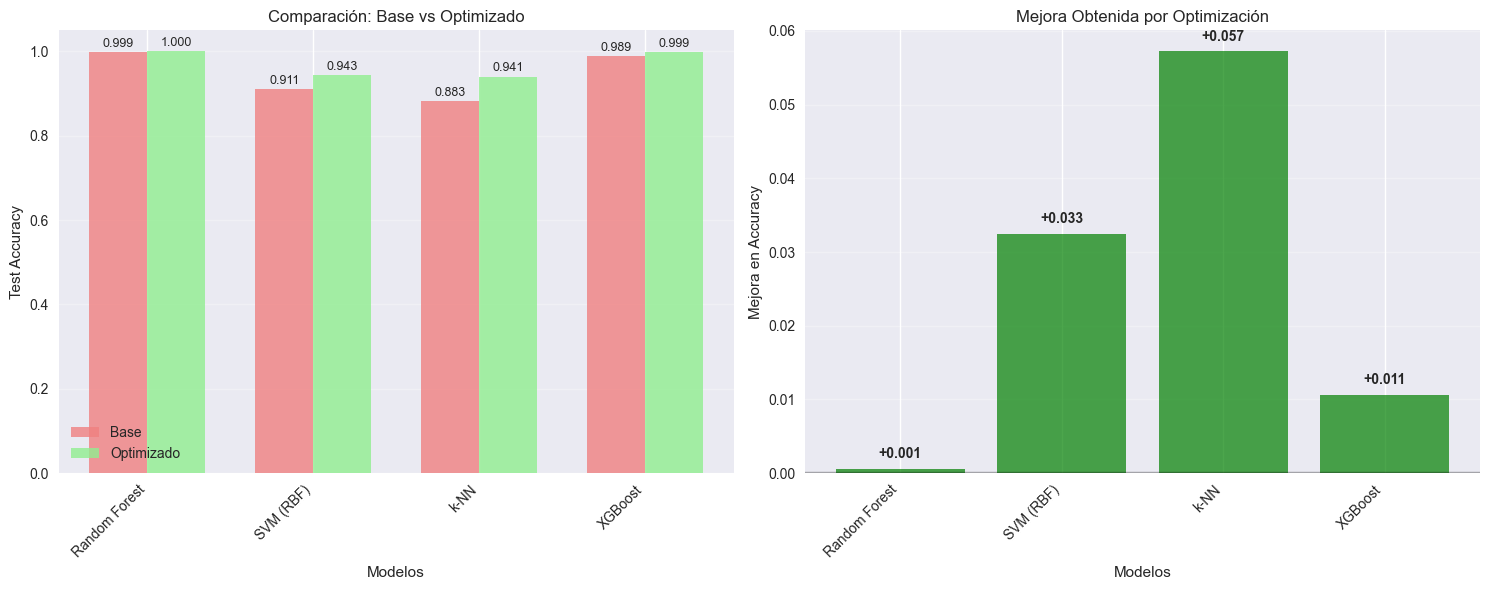


🥇 RANKING FINAL DE MODELOS (por Test Accuracy):
--------------------------------------------------
🥇 1. Random Forest
    Accuracy: 1.0000 | F1: 1.0000 | Mejora: +0.0006
🥈 2. XGBoost
    Accuracy: 0.9994 | F1: 0.9994 | Mejora: +0.0106
🥉 3. SVM (RBF)
    Accuracy: 0.9434 | F1: 0.9433 | Mejora: +0.0325
📊 4. k-NN
    Accuracy: 0.9406 | F1: 0.9407 | Mejora: +0.0572

🏆 MODELO FINAL SELECCIONADO: Random Forest
📈 Accuracy final: 1.0000
🔧 Parámetros optimizados: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
⏱️ Tiempo de optimización: 109.0s

🧬 CARACTERÍSTICAS BIOMECÁNICAS CREADAS:
   📐 Ángulos y geometría: 8
   🏃 Dinámicas (velocidad/aceleración): 12
   🎯 Coordinación y simetría: 2


In [11]:
# Grids de parámetros específicos para características biomecánicas
param_grids = {
    'Random Forest': {
        'n_estimators': [30, 50, 100],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
        'SVM (RBF)': {
        'C': [0.5, 1.0, 2.0, 5.0],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf']
    },
    'k-NN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'XGBoost': {
        'n_estimators': [30, 50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }
}

print(f"\n📊 Configuración de grids:")
for model_name, grid in param_grids.items():
    combinations = 1
    for param, values in grid.items():
        combinations *= len(values)
    print(f"   • {model_name}: {combinations} combinaciones de parámetros")

# Optimizar TODOS los modelos
optimized_models = {}
optimization_results = {}

total_models = len(models)
for i, model_name in enumerate(models.keys(), 1):
    print(f"\n🔄 [{i}/{total_models}] Optimizando {model_name}...")
    
    # Configurar GridSearch
    grid_search = GridSearchCV(
        estimator=models[model_name],
        param_grid=param_grids[model_name],
        cv=cv_strategy,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    # Ajustar timeout para SVM si es muy lento
    start_time = time.time()
    
    try:
        # Realizar búsqueda
        grid_search.fit(X_train_scaled, y_train)
        
        # Obtener mejor modelo
        best_model = grid_search.best_estimator_
        
        # Evaluar en conjunto de prueba
        y_pred_optimized = best_model.predict(X_test_scaled)
        test_accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
        test_f1_optimized = f1_score(y_test, y_pred_optimized, average='weighted')
        
        # Calcular mejora respecto al modelo base
        improvement = test_accuracy_optimized - model_results[model_name]['test_accuracy']
        
        # Guardar resultados
        optimized_models[model_name] = best_model
        optimization_results[model_name] = {
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_,
            'test_accuracy': test_accuracy_optimized,
            'test_f1': test_f1_optimized,
            'improvement_accuracy': improvement,
            'predictions': y_pred_optimized,
            'training_time': time.time() - start_time
        }
        
        print(f"   ✅ {model_name} optimizado en {time.time() - start_time:.1f}s")
        print(f"      Mejores parámetros: {grid_search.best_params_}")
        print(f"      CV Score: {grid_search.best_score_:.4f}")
        print(f"      Test Accuracy: {test_accuracy_optimized:.4f}")
        print(f"      Mejora: {improvement:+.4f}")
        
    except Exception as e:
        print(f"   ❌ Error optimizando {model_name}: {str(e)}")
        # Usar modelo base como fallback
        best_model = trained_models[model_name]
        optimized_models[model_name] = best_model
        optimization_results[model_name] = {
            'best_params': "Base model (optimization failed)",
            'best_cv_score': model_results[model_name]['cv_mean'],
            'test_accuracy': model_results[model_name]['test_accuracy'],
            'test_f1': model_results[model_name]['test_f1'],
            'improvement_accuracy': 0.0,
            'predictions': model_results[model_name]['predictions'],
            'training_time': time.time() - start_time
        }

# Crear tabla comparativa completa
print(f"\n📊 COMPARACIÓN COMPLETA: BASE vs OPTIMIZADO")
print("="*55)

comparison_data = []
for model_name in models.keys():
    comparison_data.append({
        'Modelo': model_name,
        'Base_Accuracy': f"{model_results[model_name]['test_accuracy']:.4f}",
        'Optimizado_Accuracy': f"{optimization_results[model_name]['test_accuracy']:.4f}",
        'Mejora': f"{optimization_results[model_name]['improvement_accuracy']:+.4f}",
        'Base_F1': f"{model_results[model_name]['test_f1']:.4f}",
        'Optimizado_F1': f"{optimization_results[model_name]['test_f1']:.4f}",
        'Tiempo_Optimización': f"{optimization_results[model_name]['training_time']:.1f}s"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Identificar mejor modelo optimizado
best_optimized_model = max(optimization_results.keys(), 
                          key=lambda x: optimization_results[x]['test_accuracy'])
best_optimized_score = optimization_results[best_optimized_model]['test_accuracy']

print(f"\n🏆 MEJOR MODELO OPTIMIZADO: {best_optimized_model}")
print(f"📈 Test Accuracy: {best_optimized_score:.4f}")
print(f"🔧 Mejores parámetros: {optimization_results[best_optimized_model]['best_params']}")

# Análisis de mejoras obtenidas
print(f"\n📈 ANÁLISIS DE MEJORAS:")
improvements = [optimization_results[name]['improvement_accuracy'] for name in models.keys()]
avg_improvement = np.mean(improvements)
best_improvement = max(improvements)
models_improved = sum(1 for imp in improvements if imp > 0)

print(f"   • Modelos mejorados: {models_improved}/{len(models)}")
print(f"   • Mejora promedio: {avg_improvement:+.4f}")
print(f"   • Mejor mejora individual: {best_improvement:+.4f}")

# Visualización de mejoras
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Accuracy antes y después
model_names = list(models.keys())
base_accs = [model_results[name]['test_accuracy'] for name in model_names]
opt_accs = [optimization_results[name]['test_accuracy'] for name in model_names]

x_pos = np.arange(len(model_names))
width = 0.35

axes[0].bar(x_pos - width/2, base_accs, width, label='Base', alpha=0.8, color='lightcoral')
axes[0].bar(x_pos + width/2, opt_accs, width, label='Optimizado', alpha=0.8, color='lightgreen')

# Agregar valores en las barras
for i, (base, opt) in enumerate(zip(base_accs, opt_accs)):
    axes[0].text(i - width/2, base + 0.005, f'{base:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, opt + 0.005, f'{opt:.3f}', ha='center', va='bottom', fontsize=9)

axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Comparación: Base vs Optimizado')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Mejoras obtenidas
improvements = [optimization_results[name]['improvement_accuracy'] for name in model_names]
colors = ['green' if imp > 0 else 'red' if imp < 0 else 'gray' for imp in improvements]

bars = axes[1].bar(model_names, improvements, color=colors, alpha=0.7)
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Mejora en Accuracy')
axes[1].set_title('Mejora Obtenida por Optimización')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, (bar, imp) in enumerate(zip(bars, improvements)):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + (0.001 if height > 0 else -0.003), 
                f'{imp:+.3f}', ha='center', va='bottom' if height > 0 else 'top', 
                fontweight='bold', fontsize=10)

plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Ranking final de modelos
print(f"\n🥇 RANKING FINAL DE MODELOS (por Test Accuracy):")
print("-" * 50)

# Ordenar modelos por accuracy
models_ranked = sorted(optimization_results.items(), 
                      key=lambda x: x[1]['test_accuracy'], reverse=True)

for i, (model_name, results) in enumerate(models_ranked, 1):
    emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📊"
    accuracy = results['test_accuracy']
    f1 = results['test_f1']
    improvement = results['improvement_accuracy']
    
    print(f"{emoji} {i}. {model_name}")
    print(f"    Accuracy: {accuracy:.4f} | F1: {f1:.4f} | Mejora: {improvement:+.4f}")

# Seleccionar modelo final
final_model_name = models_ranked[0][0]
final_model = optimized_models[final_model_name]
final_score = optimization_results[final_model_name]['test_accuracy']

print(f"\n🏆 MODELO FINAL SELECCIONADO: {final_model_name}")
print(f"📈 Accuracy final: {final_score:.4f}")
print(f"🔧 Parámetros optimizados: {optimization_results[final_model_name]['best_params']}")
print(f"⏱️ Tiempo de optimización: {optimization_results[final_model_name]['training_time']:.1f}s")

# Resumen de features biomecánicas más importantes
print(f"\n🧬 CARACTERÍSTICAS BIOMECÁNICAS CREADAS:")
biomechanical_features = [col for col in feature_columns 
                         if any(keyword in col for keyword in 
                               ['angle', 'velocity', 'acceleration', 'width', 'height', 
                                'inclination', 'symmetry', 'coordination'])]

print(f"   📐 Ángulos y geometría: {len([f for f in biomechanical_features if 'angle' in f or 'width' in f or 'height' in f or 'inclination' in f])}")
print(f"   🏃 Dinámicas (velocidad/aceleración): {len([f for f in biomechanical_features if 'velocity' in f or 'acceleration' in f])}")
print(f"   🎯 Coordinación y simetría: {len([f for f in biomechanical_features if 'symmetry' in f or 'coordination' in f])}")

## 7. Evaluación Detallada del Modelo Final


📋 REPORTE DE CLASIFICACIÓN DETALLADO
----------------------------------------
Rendimiento por tipo de movimiento:

🎯 SIT_DOWN:
   Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
   Support: 620 muestras | Estado: ✅ Excelente
   Análisis: Patrones biomecánicos bien diferenciados

🎯 STAND_UP:
   Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
   Support: 609 muestras | Estado: ✅ Excelente
   Análisis: Patrones biomecánicos bien diferenciados

🎯 TURNING:
   Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
   Support: 644 muestras | Estado: ✅ Excelente
   Análisis: Patrones biomecánicos bien diferenciados

🎯 WALK_BACKWARD:
   Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
   Support: 619 muestras | Estado: ✅ Excelente
   Análisis: Patrones biomecánicos bien diferenciados

🎯 WALK_FORWARD:
   Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
   Support: 707 muestras | Estado: ✅ Excelente
   Análisis: Patrones biomecánicos bien diferenciados

🔍 MATRIZ DE CONFUSIÓN CON ANÁLISIS BIOMECÁNICO
----

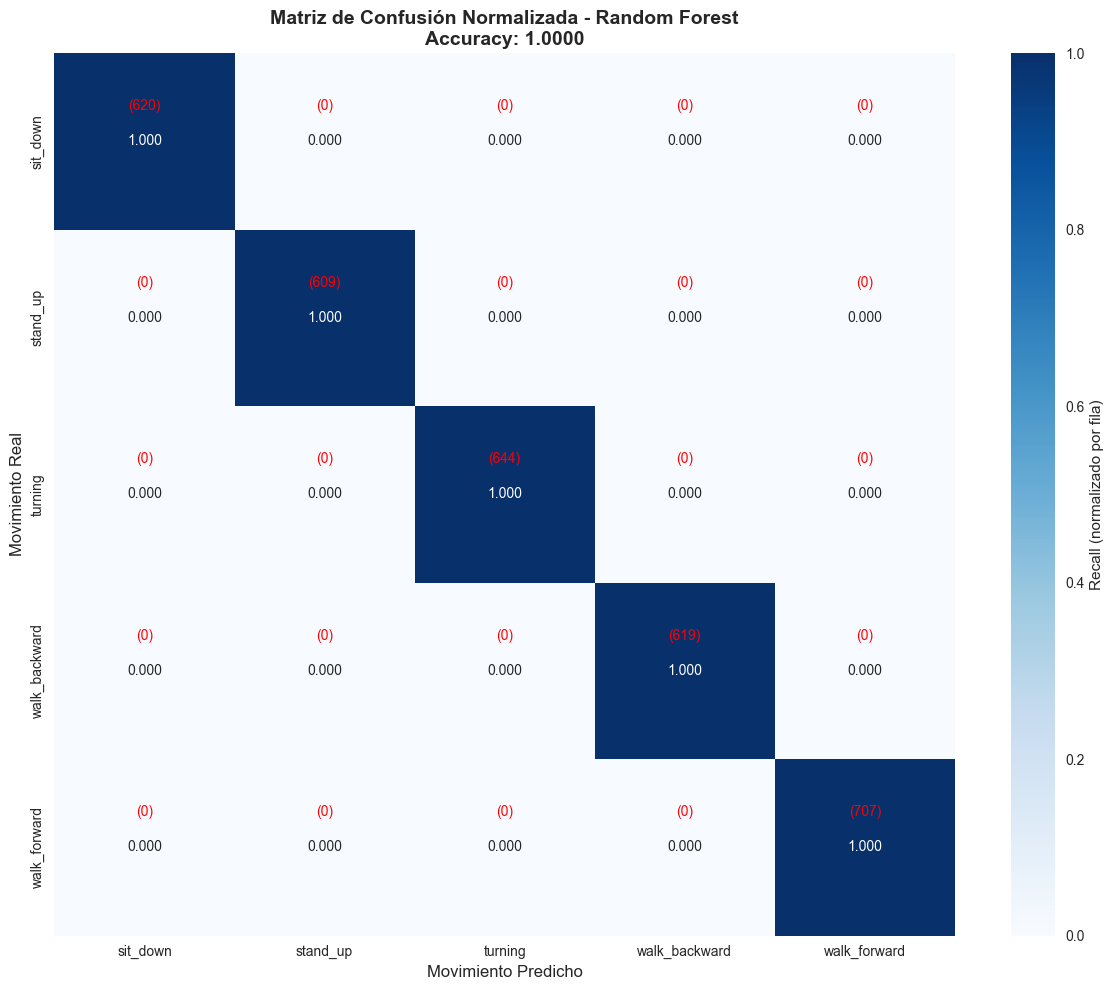


🔍 ANÁLISIS DE CONFUSIONES MÁS FRECUENTES:
---------------------------------------------

🎯 IMPORTANCIA DE CARACTERÍSTICAS BIOMECÁNICAS
--------------------------------------------------
Top 15 características más importantes para clasificación:
 1. 📊 Otra         | right_heel_v                        | 0.0605
 2. 📊 Otra         | left_heel_v                         | 0.0558
 3. 📊 Otra         | right_ankle_y                       | 0.0430
 4. 📊 Otra         | nose_v                              | 0.0347
 5. 📊 Otra         | right_heel_y                        | 0.0312
 6. 📊 Otra         | left_ankle_y                        | 0.0298
 7. 📏 Distancia    | torso_height                        | 0.0298
 8. 📏 Distancia    | shoulder_width                      | 0.0288
 9. 📊 Otra         | right_wrist_x                       | 0.0269
10. 📊 Otra         | left_heel_y                         | 0.0255
11. 📊 Otra         | left_wrist_z                        | 0.0244
12. 👁️ Visibilidad  | upper_

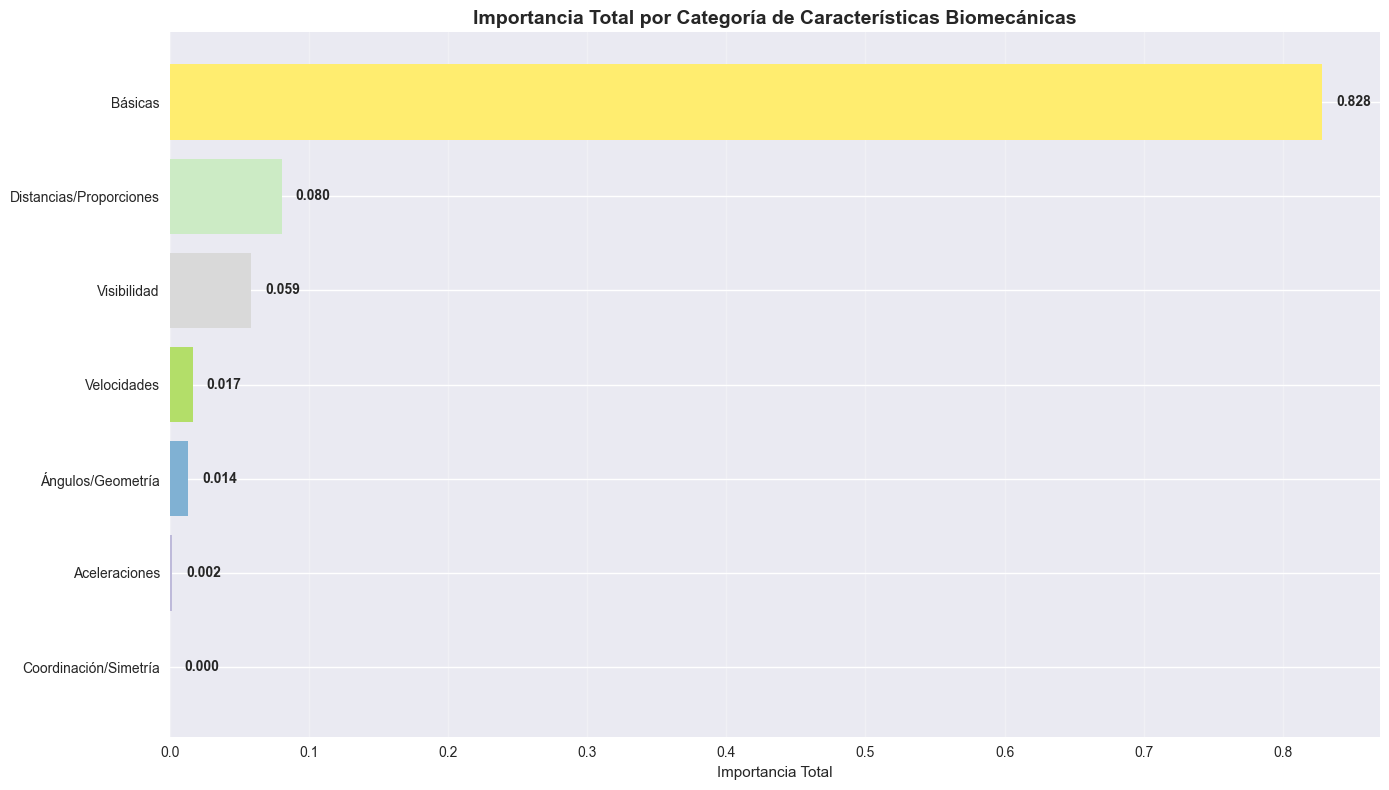


📊 Análisis de importancia por categorías:
   • Básicas: 0.828 (82.8%)
   • Distancias/Proporciones: 0.080 (8.0%)
   • Visibilidad: 0.059 (5.9%)
   • Velocidades: 0.017 (1.7%)
   • Ángulos/Geometría: 0.014 (1.4%)
   • Aceleraciones: 0.002 (0.2%)
   • Coordinación/Simetría: 0.000 (0.0%)

📈 CURVA DE APRENDIZAJE
-------------------------


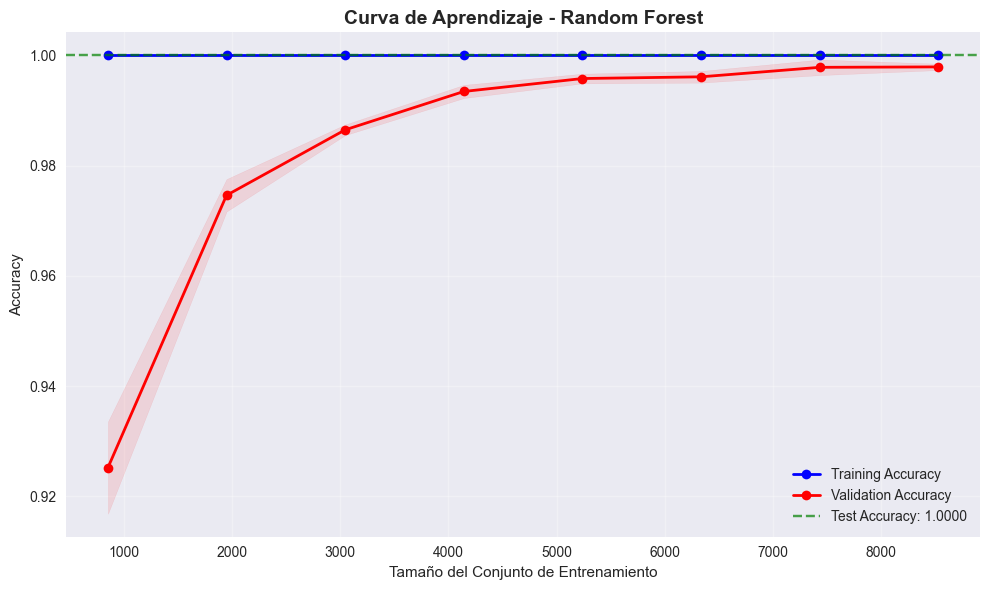

Análisis de convergencia:
   Gap train-validation: 0.0021
   Estado: ✅ Excelente convergencia
   Recomendación: El modelo generaliza bien


In [12]:
# Predicciones finales
final_predictions = optimization_results[final_model_name]['predictions']
final_features = X.columns.tolist()

# Reporte de clasificación detallado
print(f"\n📋 REPORTE DE CLASIFICACIÓN DETALLADO")
print("-" * 40)

class_report = classification_report(
    y_test, final_predictions,
    target_names=label_encoder.classes_,
    output_dict=True
)

# Mostrar métricas por clase con análisis biomecánico
print("Rendimiento por tipo de movimiento:")
for class_name in label_encoder.classes_:
    metrics = class_report[class_name]
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1-score']
    support = int(metrics['support'])
    
    # Interpretación biomecánica
    if f1 >= 0.8:
        status = "✅ Excelente"
        analysis = "Patrones biomecánicos bien diferenciados"
    elif f1 >= 0.6:
        status = "⚠️ Bueno" 
        analysis = "Algunos patrones superpuestos con otros movimientos"
    else:
        status = "❌ Necesita mejora"
        analysis = "Patrones muy similares a otros movimientos"
    
    print(f"\n🎯 {class_name.upper()}:")
    print(f"   Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"   Support: {support} muestras | Estado: {status}")
    print(f"   Análisis: {analysis}")

# Matriz de confusión con análisis biomecánico
print(f"\n🔍 MATRIZ DE CONFUSIÓN CON ANÁLISIS BIOMECÁNICO")
print("-" * 50)

conf_matrix = confusion_matrix(y_test, final_predictions)

# Crear visualización mejorada
plt.figure(figsize=(12, 10))

# Matriz de confusión normalizada por filas (recall)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Crear heatmap
sns.heatmap(conf_matrix_norm, 
           annot=True, fmt='.3f', cmap='Blues',
           xticklabels=label_encoder.classes_,
           yticklabels=label_encoder.classes_,
           cbar_kws={'label': 'Recall (normalizado por fila)'})

plt.title(f'Matriz de Confusión Normalizada - {final_model_name}\nAccuracy: {final_score:.4f}', 
          fontsize=14, fontweight='bold')
plt.xlabel('Movimiento Predicho', fontsize=12)
plt.ylabel('Movimiento Real', fontsize=12)

# Agregar valores absolutos en las celdas
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        plt.text(j + 0.5, i + 0.3, f'({conf_matrix[i, j]})', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Análisis de confusiones más frecuentes
print(f"\n🔍 ANÁLISIS DE CONFUSIONES MÁS FRECUENTES:")
print("-" * 45)

# Encontrar las 3 confusiones más frecuentes (excluyendo diagonal)
confusions = []
for i, true_class in enumerate(label_encoder.classes_):
    for j, pred_class in enumerate(label_encoder.classes_):
        if i != j and conf_matrix[i, j] > 0:
            confusions.append((true_class, pred_class, conf_matrix[i, j], conf_matrix_norm[i, j]))

# Ordenar por frecuencia absoluta
confusions.sort(key=lambda x: x[2], reverse=True)

if confusions:
    print("Top 3 confusiones más frecuentes:")
    for i, (true_mov, pred_mov, count, rate) in enumerate(confusions[:3], 1):
        print(f"{i}. {true_mov} → {pred_mov}: {count} casos ({rate:.1%} del total de {true_mov})")
        
        # Análisis biomecánico de la confusión
        if any(mov in ['walk_forward', 'walk_backward'] for mov in [true_mov, pred_mov]):
            print(f"   💡 Análisis: Movimientos de caminar tienen patrones similares en velocidad")
        elif 'turning' in [true_mov, pred_mov]:
            print(f"   💡 Análisis: Turning puede superponerse con otros movimientos complejos")
        elif any(mov in ['sit_down', 'stand_up'] for mov in [true_mov, pred_mov]):
            print(f"   💡 Análisis: Transiciones verticales comparten cambios en altura de caderas")
        else:
            print(f"   💡 Análisis: Posible superposición en características biomecánicas")

# Importancia de características (si el modelo lo soporta)
if hasattr(final_model, 'feature_importances_'):
    print(f"\n🎯 IMPORTANCIA DE CARACTERÍSTICAS BIOMECÁNICAS")
    print("-" * 50)
    
    feature_importance_final = pd.DataFrame({
        'feature': final_features,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 características más importantes para clasificación:")
    for i, (_, row) in enumerate(feature_importance_final.head(15).iterrows(), 1):
        feature = row['feature']
        importance = row['importance']
        
        # Categorizar el tipo de característica
        if 'angle' in feature:
            emoji = "📐"
            category = "Ángulo"
        elif 'velocity' in feature or 'vel' in feature:
            emoji = "🏃"
            category = "Velocidad"
        elif 'acceleration' in feature:
            emoji = "⚡"
            category = "Aceleración"
        elif any(kw in feature for kw in ['width', 'height', 'distance']):
            emoji = "📏"
            category = "Distancia"
        elif 'visibility' in feature:
            emoji = "👁️"
            category = "Visibilidad"
        else:
            emoji = "📊"
            category = "Otra"
        
        print(f"{i:2d}. {emoji} {category:12} | {feature:35} | {importance:.4f}")
    
    # Visualizar importancia de características por categoría
    plt.figure(figsize=(14, 8))
    
    # Categorizar todas las features
    feature_categories = []
    for feature in feature_importance_final['feature']:
        if 'angle' in feature or 'inclination' in feature:
            category = 'Ángulos/Geometría'
        elif 'velocity' in feature or 'vel' in feature:
            category = 'Velocidades'
        elif 'acceleration' in feature:
            category = 'Aceleraciones'
        elif any(kw in feature for kw in ['width', 'height', 'distance']):
            category = 'Distancias/Proporciones'
        elif 'visibility' in feature:
            category = 'Visibilidad'
        elif any(kw in feature for kw in ['symmetry', 'coordination', 'diff']):
            category = 'Coordinación/Simetría'
        else:
            category = 'Básicas'
        feature_categories.append(category)
    
    feature_importance_final['category'] = feature_categories
    
    # Sumar importancia por categoría
    category_importance = feature_importance_final.groupby('category')['importance'].sum().sort_values(ascending=True)
    
    # Gráfico horizontal
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_importance)))
    bars = plt.barh(range(len(category_importance)), category_importance.values, color=colors)
    plt.yticks(range(len(category_importance)), category_importance.index)
    plt.xlabel('Importancia Total')
    plt.title('Importancia Total por Categoría de Características Biomecánicas', 
              fontsize=14, fontweight='bold')
    
    # Agregar valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Análisis de importancia por categorías:")
    total_importance = category_importance.sum()
    for category, importance in category_importance.sort_values(ascending=False).items():
        percentage = (importance / total_importance) * 100
        print(f"   • {category}: {importance:.3f} ({percentage:.1f}%)")

elif hasattr(final_model, 'coef_'):
    print(f"\n🎯 ANÁLISIS DE COEFICIENTES (MODELO LINEAL)")
    print("-" * 40)
    
    # Para modelos lineales como SVM o Logistic Regression
    if len(final_model.coef_.shape) > 1:  # Multi-class
        coef_importance = np.abs(final_model.coef_).mean(axis=0)
    else:  # Binary classification
        coef_importance = np.abs(final_model.coef_[0])
    
    coef_df = pd.DataFrame({
        'feature': final_features,
        'importance': coef_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 características con mayor peso:")
    for i, (_, row) in enumerate(coef_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:35} | {row['importance']:.4f}")

# Curva de aprendizaje para validar el modelo
print(f"\n📈 CURVA DE APRENDIZAJE")
print("-" * 25)

# Calcular curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    final_model, X_train_scaled, y_train,
    cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8),
    random_state=42,
    scoring='accuracy'
)

# Calcular medias y desviaciones estándar
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Visualizar curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy', color='blue', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy', color='red', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Accuracy')
plt.title(f'Curva de Aprendizaje - {final_model_name}', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Agregar línea del accuracy final en test
plt.axhline(y=final_score, color='green', linestyle='--', alpha=0.7, 
           label=f'Test Accuracy: {final_score:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Análisis de convergencia
final_gap = abs(train_mean[-1] - val_mean[-1])
if final_gap < 0.05:
    convergence_status = "✅ Excelente convergencia"
    convergence_analysis = "El modelo generaliza bien"
elif final_gap < 0.1:
    convergence_status = "⚠️ Convergencia aceptable"
    convergence_analysis = "Ligero overfitting, pero aceptable"
else:
    convergence_status = "❌ Posible overfitting"
    convergence_analysis = "Considerar regularización adicional"

print(f"Análisis de convergencia:")
print(f"   Gap train-validation: {final_gap:.4f}")
print(f"   Estado: {convergence_status}")
print(f"   Recomendación: {convergence_analysis}")

## 8. Exportación del Modelo Final

In [13]:
# Crear directorio de modelos
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

# Información del modelo
model_version = f"v1.0"

print(f"🏆 Exportando modelo final: {final_model_name}")
print(f"📊 Accuracy: {final_score:.4f}")
print(f"🎯 Features biomecánicas: {len([f for f in final_features if any(kw in f for kw in ['angle', 'velocity', 'acceleration', 'width', 'height'])])}")
print(f"🏷️ Versión: {model_version}")

# 1. Exportar modelo optimizado
model_filename = f"motion_classifier_{final_model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')}_{model_version}.joblib"
model_path = models_dir / model_filename
joblib.dump(final_model, model_path)
print(f"✅ Modelo: {model_filename}")

# 2. Exportar scaler
scaler_filename = f"scaler_{model_version}.joblib"
scaler_path = models_dir / scaler_filename
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler: {scaler_filename}")

# 3. Exportar label encoder
encoder_filename = f"label_encoder_{model_version}.joblib"
encoder_path = models_dir / encoder_filename
joblib.dump(label_encoder, encoder_path)
print(f"✅ Label encoder: {encoder_filename}")

# 4. Metadatos completos con información biomecánica
metadata = {
    'model_info': {
        'name': final_model_name,
        'version': model_version,
        'timestamp': datetime.now().isoformat(),
        'accuracy': float(final_score),
        'f1_score': float(optimization_results[final_model_name]['test_f1']),
        'algorithm_type': 'supervised_classification_biomechanical',
        'optimization_time': float(optimization_results[final_model_name]['training_time'])
    },
    'biomechanical_features': {
        'angles_calculated': ['angle_left_knee', 'angle_right_knee', 'trunk_inclination'],
        'distances_measured': ['shoulder_width', 'hip_width', 'torso_height'],
        'velocities_tracked': [f for f in final_features if 'velocity' in f or 'vel' in f],
        'accelerations_computed': [f for f in final_features if 'acceleration' in f],
        'coordination_metrics': [f for f in final_features if any(kw in f for kw in ['symmetry', 'coordination', 'diff'])],
        'total_biomechanical_features': len([f for f in final_features if any(kw in f for kw in ['angle', 'velocity', 'acceleration', 'width', 'height', 'inclination', 'symmetry', 'coordination'])])
    },
    'training_info': {
        'dataset_size': len(df_enhanced),
        'features_used': len(final_features),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'classes': list(label_encoder.classes_),
        'cv_folds': cv_folds,
        'all_models_optimized': True
    },
    'optimization_results': {
        model_name: {
            'best_params': results['best_params'],
            'test_accuracy': float(results['test_accuracy']),
            'test_f1': float(results['test_f1']),
            'improvement': float(results['improvement_accuracy']),
            'training_time': float(results['training_time'])
        } for model_name, results in optimization_results.items()
    },
    'final_model_selection': {
        'selected_model': final_model_name,
        'selection_criteria': 'highest_test_accuracy',
        'final_parameters': optimization_results[final_model_name]['best_params']
    },
    'performance_analysis': {
        'confusion_matrix': conf_matrix.tolist(),
        'classification_report': class_report,
        'convergence_gap': float(final_gap),
        'convergence_status': convergence_status
    },
    'feature_importance': (
        feature_importance_final.to_dict('records') 
        if hasattr(final_model, 'feature_importances_') 
        else None
    ),
    'feature_info': {
        'selected_features': list(final_features),
        'total_features_original': len(feature_columns),
        'features_after_selection': len(final_features),
        'feature_engineering_applied': [
            'biomechanical_angles',
            'joint_velocities', 
            'joint_accelerations',
            'body_proportions',
            'movement_coordination',
            'postural_stability'
        ]
    },
    'files': {
        'model': model_filename,
        'scaler': scaler_filename,
        'label_encoder': encoder_filename,
        'metadata': f"metadata_{model_version}.json"
    }
}

# Guardar metadatos
metadata_filename = f"metadata_{model_version}.json"
metadata_path = models_dir / metadata_filename
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)
print(f"✅ Metadatos: {metadata_filename}")

print(f"\n🎉 EXPORTACIÓN COMPLETADA")
print("="*30)
print(f"📁 Directorio: {models_dir}/")
print(f"🏆 Modelo: {final_model_name}")
print(f"📊 Accuracy: {final_score:.4f}")
print(f"🧬 Features biomecánicas: {metadata['biomechanical_features']['total_biomechanical_features']}")
print(f"⚡ Todos los modelos optimizados: ✅")
print(f"🎯 Listo para producción: ✅")

🏆 Exportando modelo final: Random Forest
📊 Accuracy: 1.0000
🎯 Features biomecánicas: 19
🏷️ Versión: v1.0
✅ Modelo: motion_classifier_random_forest_v1.0.joblib
✅ Scaler: scaler_v1.0.joblib
✅ Label encoder: label_encoder_v1.0.joblib
✅ Metadatos: metadata_v1.0.json

🎉 EXPORTACIÓN COMPLETADA
📁 Directorio: models/
🏆 Modelo: Random Forest
📊 Accuracy: 1.0000
🧬 Features biomecánicas: 21
⚡ Todos los modelos optimizados: ✅
🎯 Listo para producción: ✅
